In [1]:
from cohirf.experiment.hpo_spherical_clustering_experiment import HPOSphericalClusteringExperiment
from cohirf.experiment.spherical_clustering_experiment import SphericalClusteringExperiment
from pathlib import Path
from cohirf.models.batch_cohirf import BatchCoHiRF
from cohirf.models.cohirf import BaseCoHiRF
from sklearn.cluster import DBSCAN
import optuna
import matplotlib.pyplot as plt
import numpy as np
from ml_experiments.utils import update_recursively, unflatten_any

In [2]:
results_dir = Path("/home/belucci/code/cohirf/results") / "spheres"
mlflow_tracking_uri = f"sqlite:///{results_dir}/mlflow.db"

In [3]:
experiment_params = dict(
    mlflow_tracking_uri=mlflow_tracking_uri,
    check_if_exists=False,
	verbose=1,
)
n_trials = 20
hpo_metric = "adjusted_rand"
direction = "maximize"

# Example of running one of the defined tested models

In [ ]:
n_spheres = 2
radius_separation = 0.5
radius_std = 0.01
n_samples = 2000
model = "DBSCAN"
seed_dataset = 0
hpo_experiment = HPOSphericalClusteringExperiment(
    # hpo
    n_trials=n_trials,
    hpo_seed=seed_dataset,
    hpo_metric=hpo_metric,
    direction=direction,
    # model
    experiment_name=f"{model}_hpo",
    model=model,
    seed_model=seed_dataset,
    # dataset
    seed_dataset=seed_dataset,
    n_samples=n_samples,
    n_spheres=n_spheres,
    radius_separation=radius_separation,
    radius_std=radius_std,
    **experiment_params,
)
result = hpo_experiment.run(return_results=True)[0]
ari = result["evaluate_model_return"]["best/adjusted_rand"]
hpo_time = result["fit_model_return"]["elapsed_time"]
best_time = result["evaluate_model_return"]["best/elapsed_time"]
best_params = result["fit_model_return"]["study"].best_params
best_seed = result["fit_model_return"]["study"].best_trial.user_attrs["result"]["seed_model"]

# Example of running a custom model

In [ ]:
model_cls = BatchCoHiRF
model_params = dict(
    cohirf_model=BaseCoHiRF,
    cohirf_kwargs=dict(base_model=DBSCAN, max_iter=1),
    n_batches=10,
    n_jobs=10,
)
search_space = dict(
    cohirf_kwargs=dict(
        n_features=optuna.distributions.FloatDistribution(0.1, 1),
        repetitions=optuna.distributions.IntDistribution(1, 10),
        base_model_kwargs=dict(
            eps=optuna.distributions.FloatDistribution(1e-1, 10),
            min_samples=optuna.distributions.IntDistribution(2, 50),
        ),
    )
)
default_values = [
    dict(
        cohirf_kwargs=dict(
            n_features=0.3,
            repetitions=5,
            base_model_kwargs=dict(
                eps=0.5,
                min_samples=5,
            ),
        )
    ),
]

In [11]:
experiment = HPOSphericalClusteringExperiment(
    # hpo
    n_trials=20,
    hpo_seed=0,
    hpo_metric="adjusted_rand",
    direction="maximize",
    # model
    model=model_cls,
	model_params=model_params,
	search_space=search_space,
	default_values=default_values,
    # dataset
    seed_dataset=0,
    n_samples=2000,
    n_spheres=2,
    radius_separation=0.5,
    radius_std=0.01,
    verbose=0,
    **experiment_params,
)
result = experiment.run(return_results=True)[0]
ari = result["evaluate_model_return"]["best/adjusted_rand"]
hpo_time = result["fit_model_return"]["elapsed_time"]
best_time = result["evaluate_model_return"]["best/elapsed_time"]

2025/07/19 18:46:25 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/19 18:46:25 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

# Illustrative examples

In [4]:
def plot_3d_example(n_spheres, radius_separation, radius_std, n_samples, model, seed_dataset, n_trials, model_params=None):
    hpo_experiment = HPOSphericalClusteringExperiment(
        # hpo
        n_trials=n_trials,
        hpo_seed=seed_dataset,
        hpo_metric=hpo_metric,
        direction=direction,
        # model
        experiment_name=f"{model}_hpo",
        model=model,
        seed_model=seed_dataset,
        model_params=model_params,
        # dataset
        seed_dataset=seed_dataset,
        n_samples=n_samples,
        n_spheres=n_spheres,
        radius_separation=radius_separation,
        radius_std=radius_std,
        calculate_metrics_even_if_too_many_clusters=True,
        **experiment_params,
    )
    result = hpo_experiment.run(return_results=True)[0]
    best_params = result["fit_model_return"]["study"].best_params
    best_params = unflatten_any(best_params)
    if model_params is not None:
        best_params = update_recursively(best_params, model_params)
    best_seed = result["fit_model_return"]["study"].best_trial.user_attrs["result"]["seed_model"]
    experiment = SphericalClusteringExperiment(
        model=model,
        seed_model=best_seed,
        model_params=best_params,
        n_samples=n_samples,
        n_spheres=n_spheres,
        radius_separation=radius_separation,
        radius_std=radius_std,
        seed_dataset=seed_dataset,
        experiment_name=f"{model}_best",
        **experiment_params,
    )
    result = experiment.run(return_results=True)[0]
    features = result["load_data_return"]["X"]
    y_true = result["load_data_return"]["y"]
    labels = result["fit_model_return"]["y_pred"]
    cluster_labels = np.unique(y_true)

    # Set up the figure with high DPI for publication quality
    fig = plt.figure(figsize=(10, 8), dpi=300)
    ax = fig.add_subplot(111, projection="3d")

    # Define colors for each cluster (using colorblind-friendly palette)
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    cluster_labels = np.unique(labels)

    # Plot each cluster with different colors
    for i, label in enumerate(cluster_labels):
        mask = labels == label
        cluster_points = features[mask]
        ax.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            cluster_points[:, 2],
            c=colors[i % len(colors)],
            alpha=0.7,
            s=40,
            label=f"Cluster {label + 1}",
            edgecolors="black",
            linewidth=0.1,
        )

    # Set viewing angle for optimal visualization
    ax.view_init(elev=20, azim=45)

    # Make the plot look more professional
    ax.grid(True, alpha=0.3)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Make pane edges more subtle
    ax.xaxis.pane.set_edgecolor("gray")
    ax.yaxis.pane.set_edgecolor("gray")
    ax.zaxis.pane.set_edgecolor("gray")
    ax.xaxis.pane.set_alpha(0.1)
    ax.yaxis.pane.set_alpha(0.1)
    ax.zaxis.pane.set_alpha(0.1)

    return fig, ax, result

# DBSCAN

In [6]:
n_spheres = 2
radius_separation = 0.5
radius_std = 0.01
n_samples = 2000
model = "DBSCAN"
seed_dataset = 0


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

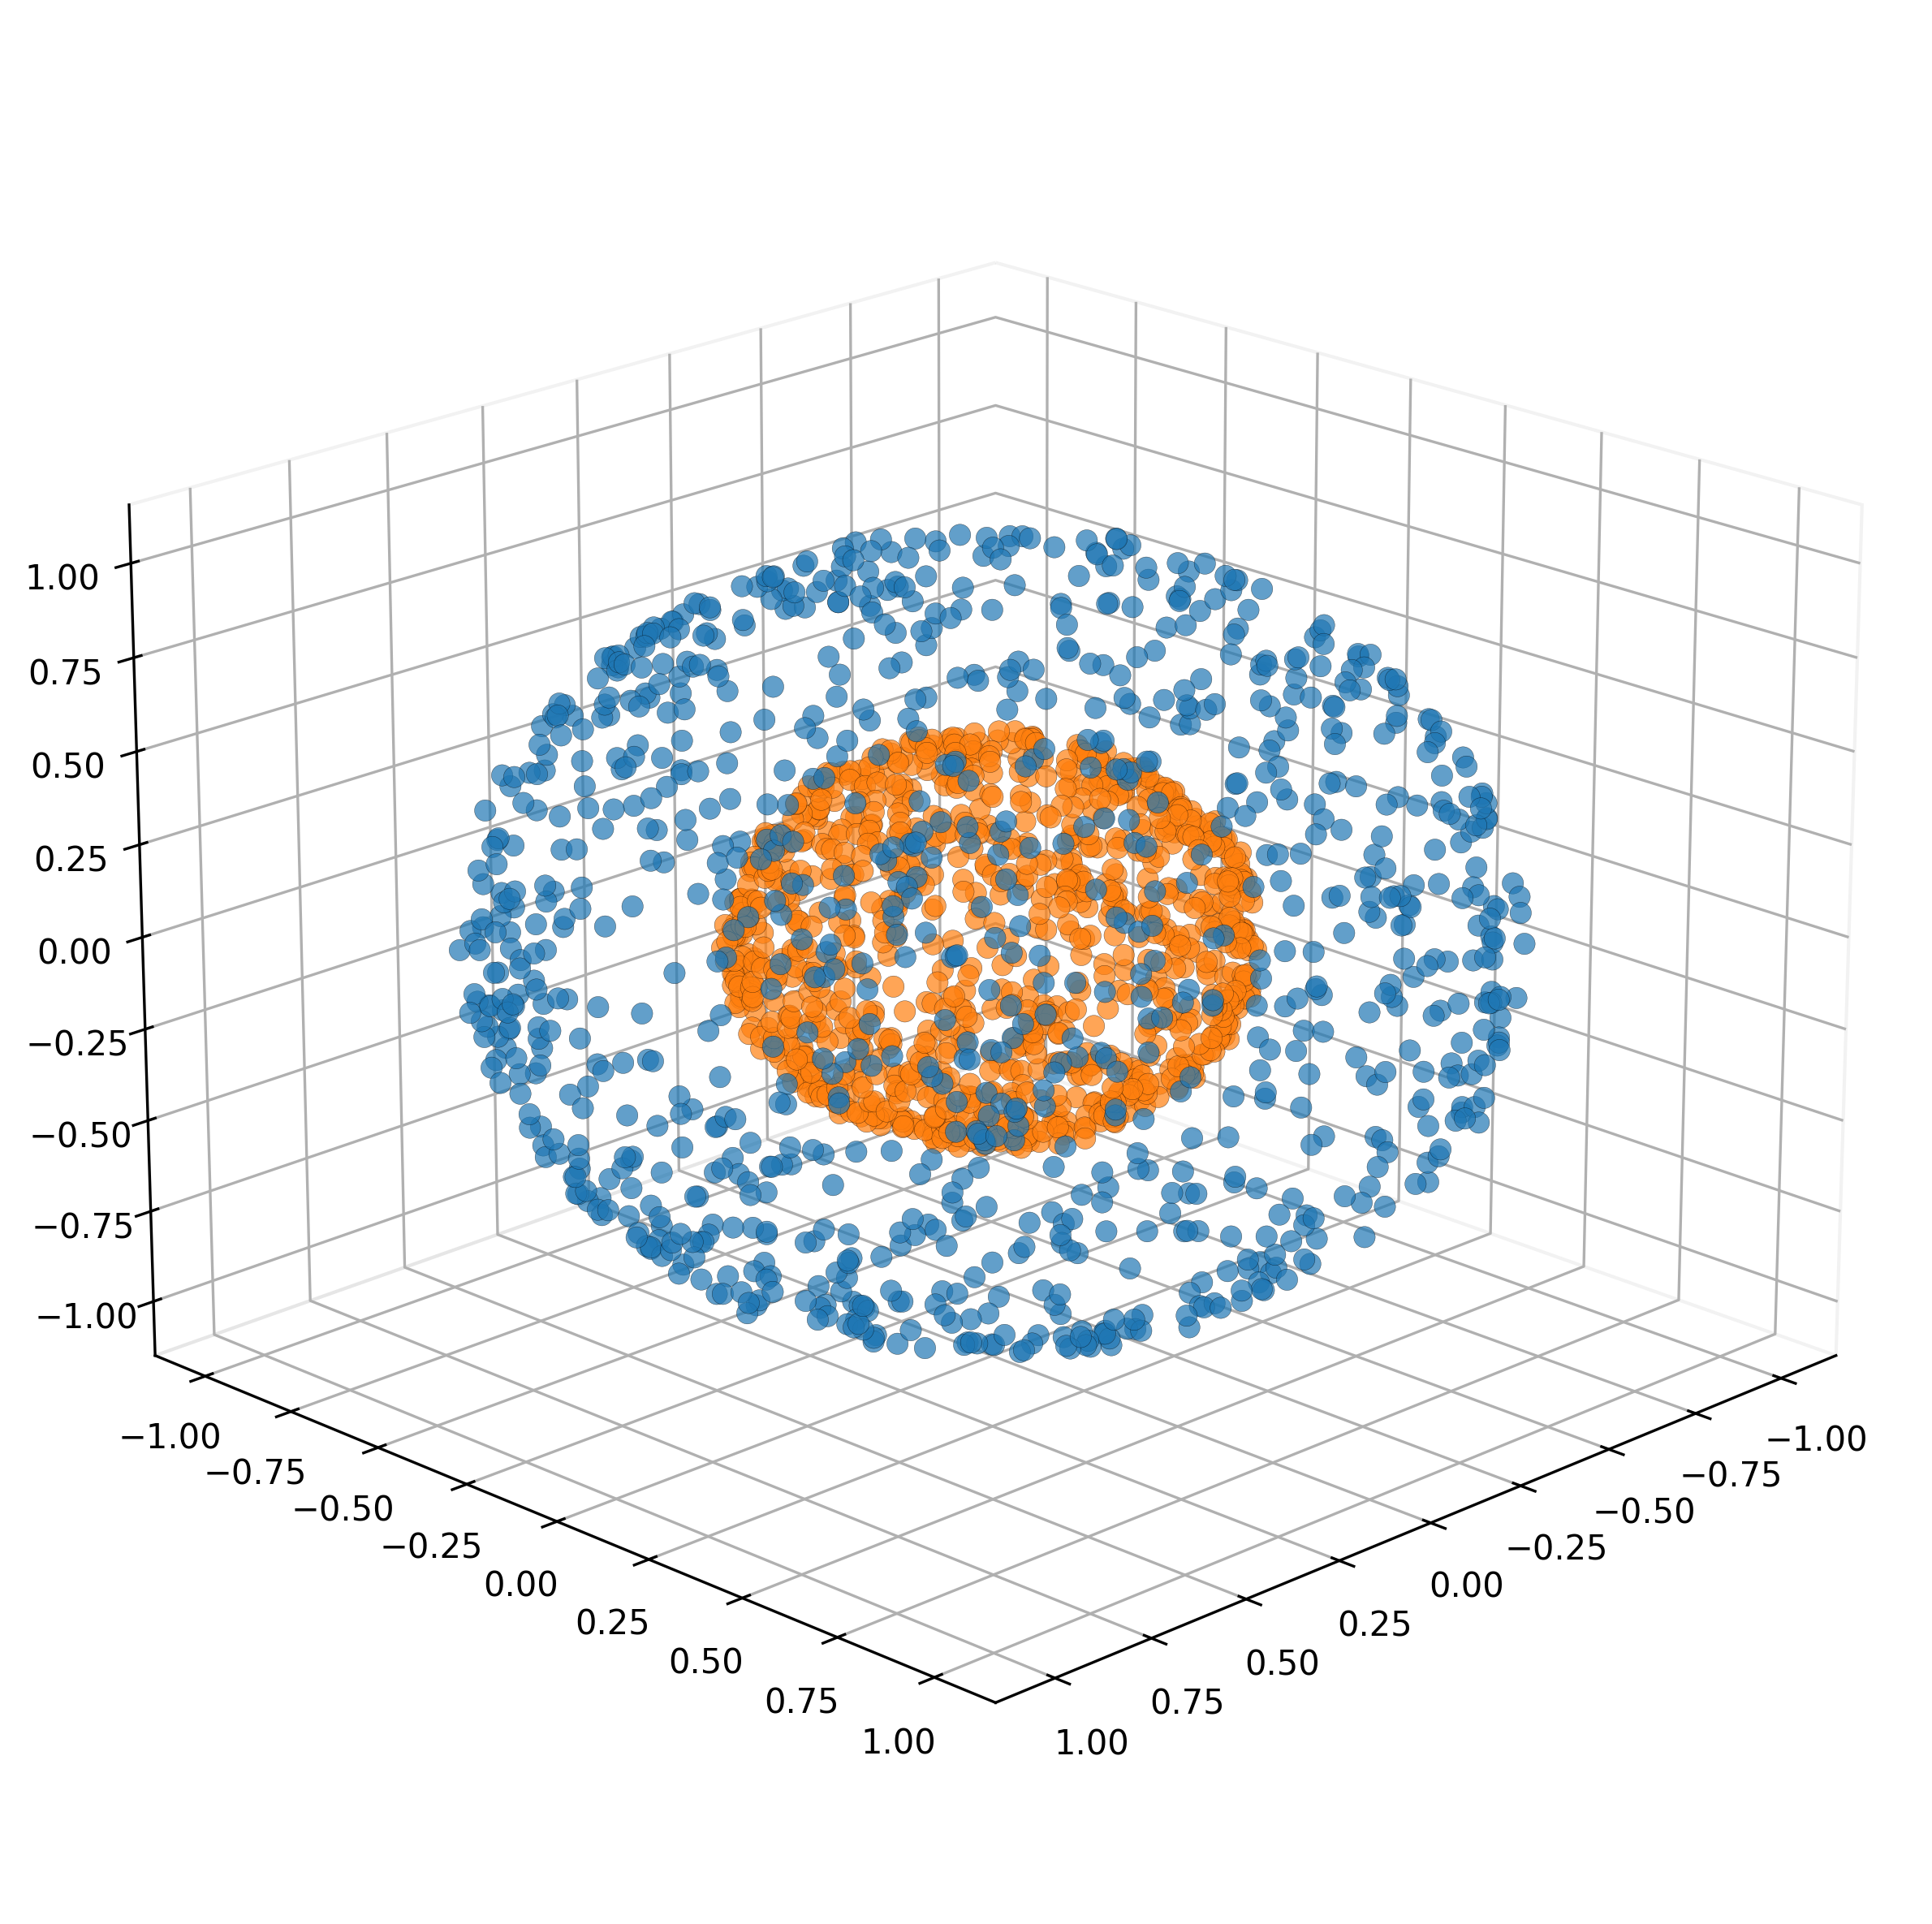

In [23]:
fig, ax, result = plot_3d_example(
    n_spheres, radius_separation, radius_std, n_samples, model, seed_dataset, n_trials=n_trials
)
plt.tight_layout()
fig.savefig(results_dir / f"{model}_spherical_clusters_3d.pdf", dpi=300)

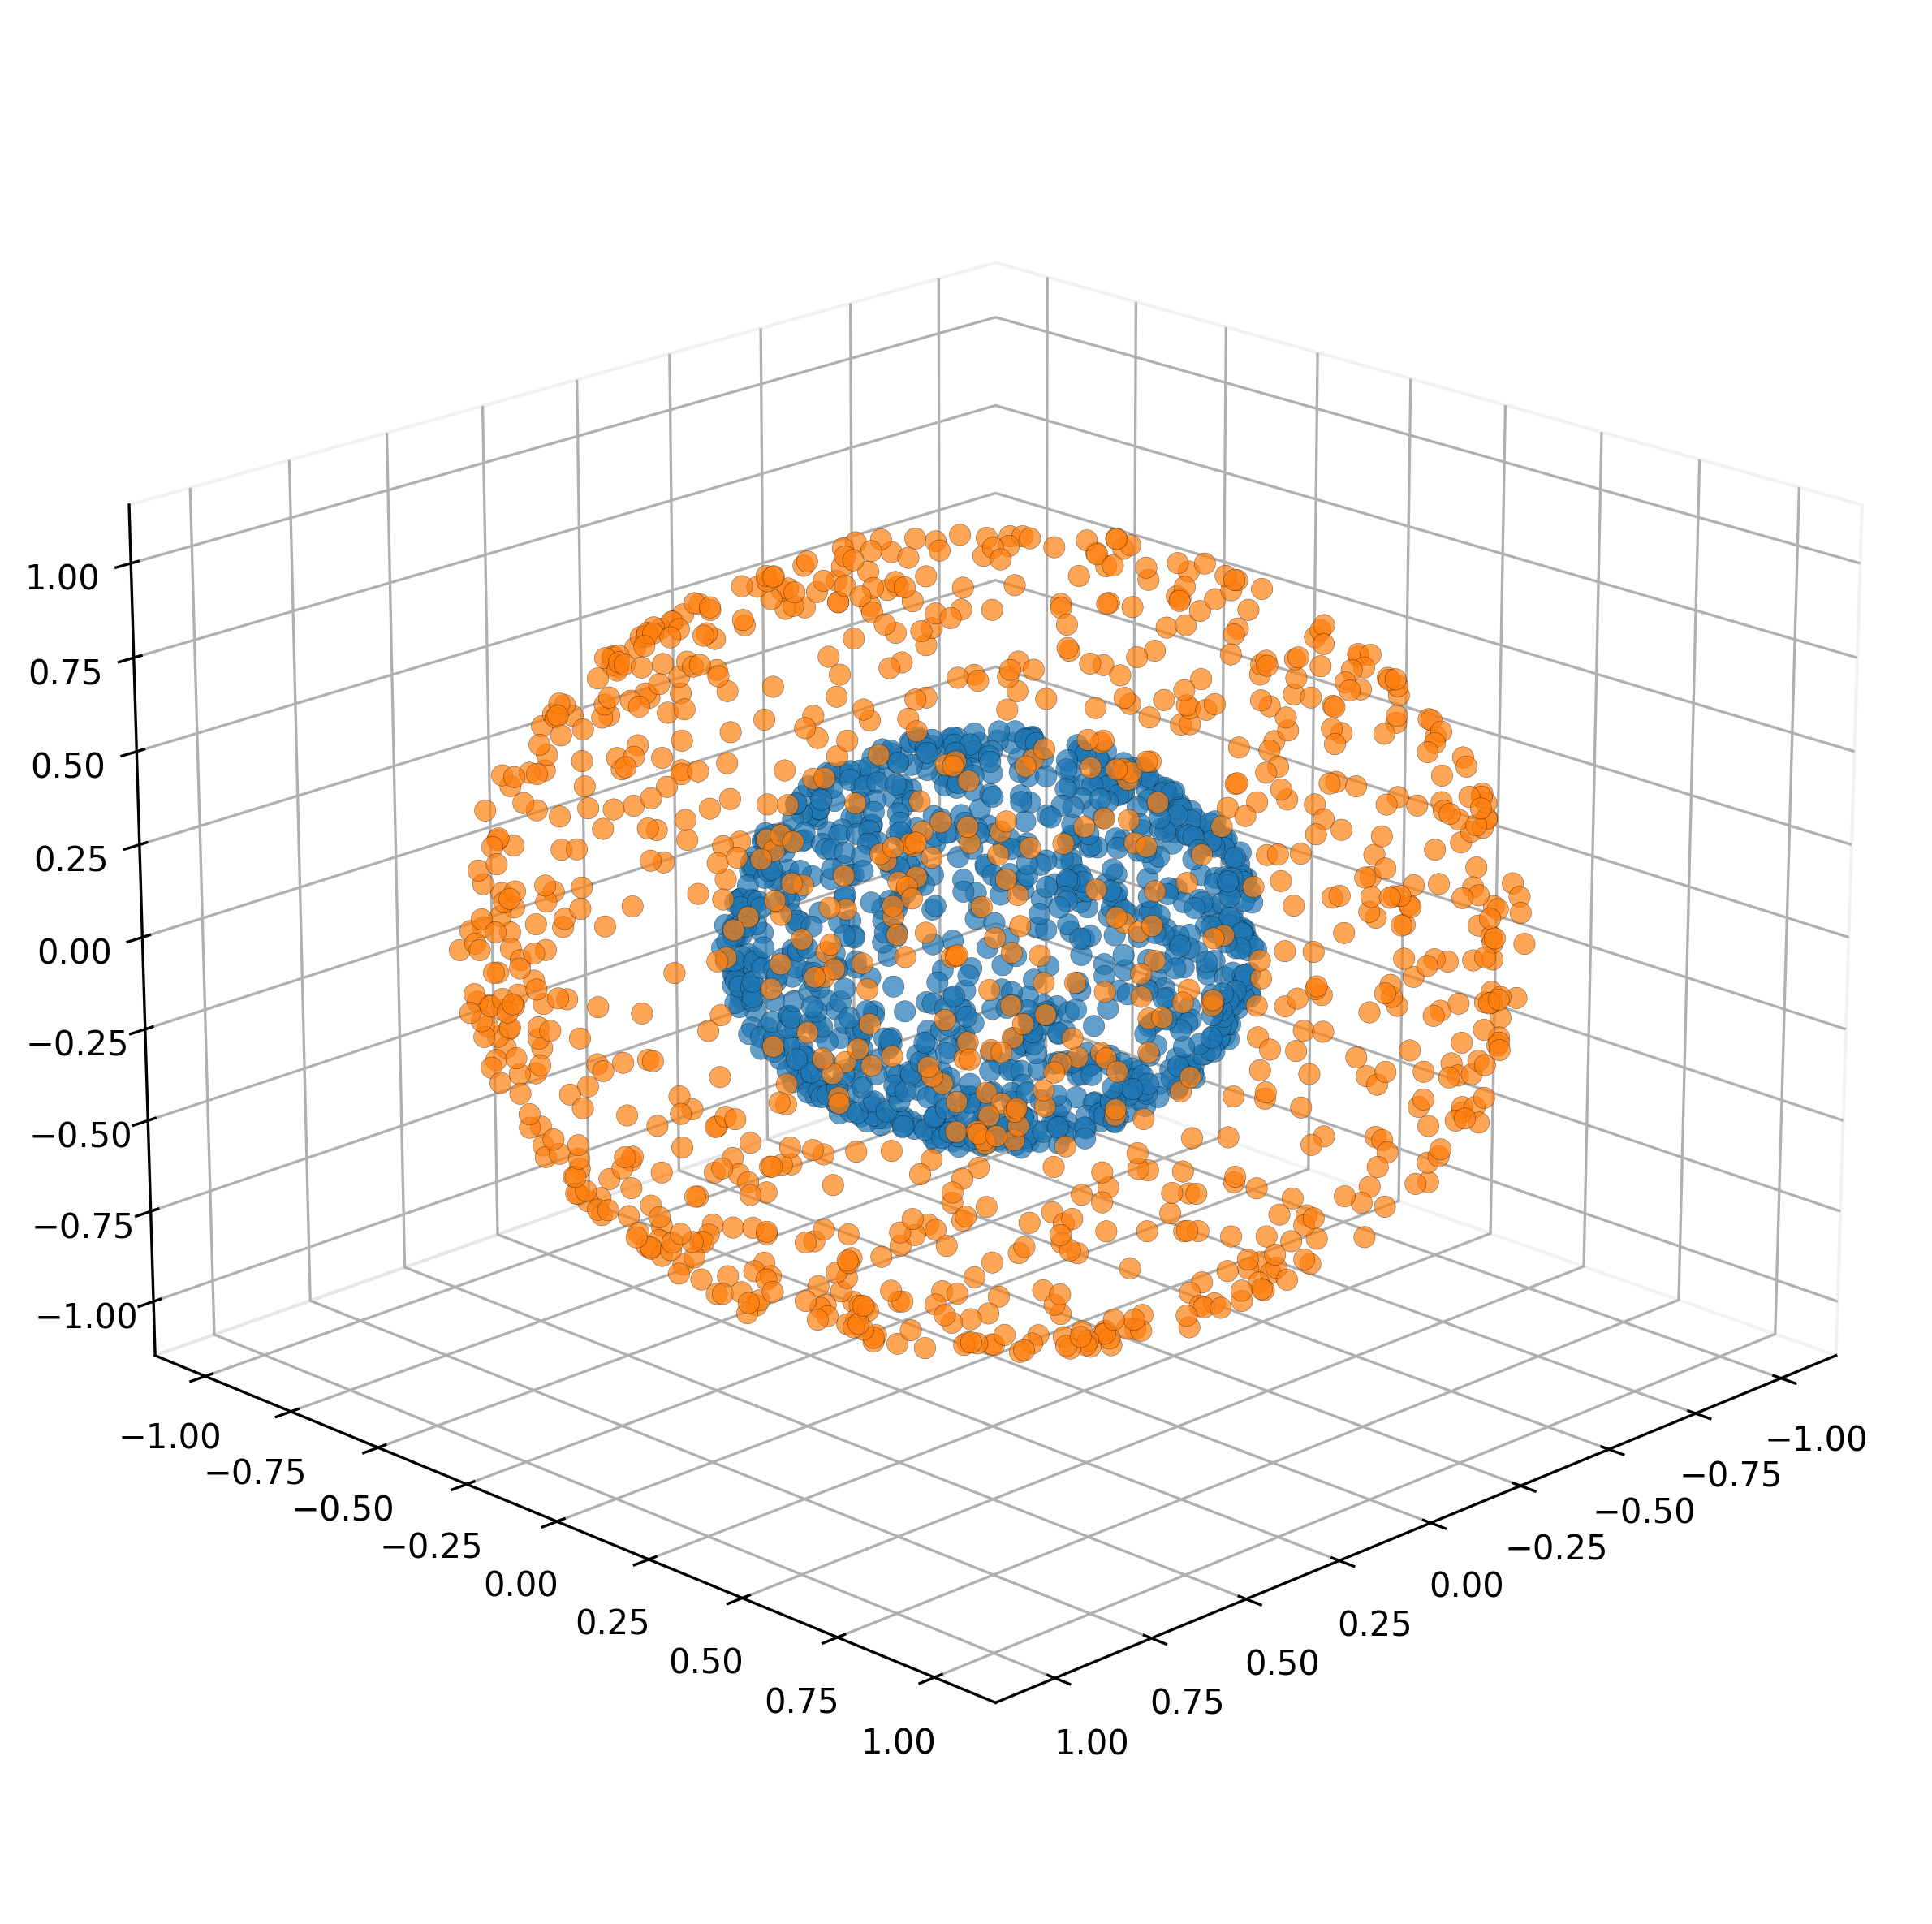

In [24]:
features = result["load_data_return"]["X"]
y_true = result["load_data_return"]["y"]
labels = y_true
cluster_labels = np.unique(y_true)

# Set up the figure with high DPI for publication quality
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot(111, projection="3d")

# Define colors for each cluster (using colorblind-friendly palette)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
cluster_labels = np.unique(labels)

# Plot each cluster with different colors
for i, label in enumerate(cluster_labels):
    mask = labels == label
    cluster_points = features[mask]
    ax.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        cluster_points[:, 2],
        c=colors[i % len(colors)],
        alpha=0.7,
        s=40,
        label=f"Cluster {label + 1}",
        edgecolors="black",
        linewidth=0.1,
    )

# Set viewing angle for optimal visualization
ax.view_init(elev=20, azim=45)

# Make the plot look more professional
ax.grid(True, alpha=0.3)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Make pane edges more subtle
ax.xaxis.pane.set_edgecolor("gray")
ax.yaxis.pane.set_edgecolor("gray")
ax.zaxis.pane.set_edgecolor("gray")
ax.xaxis.pane.set_alpha(0.1)
ax.yaxis.pane.set_alpha(0.1)
ax.zaxis.pane.set_alpha(0.1)

# Tight layout for better spacing
plt.tight_layout()
plt.savefig(results_dir / "spherical_clusters_3d.pdf", dpi=300)

# KMeans

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

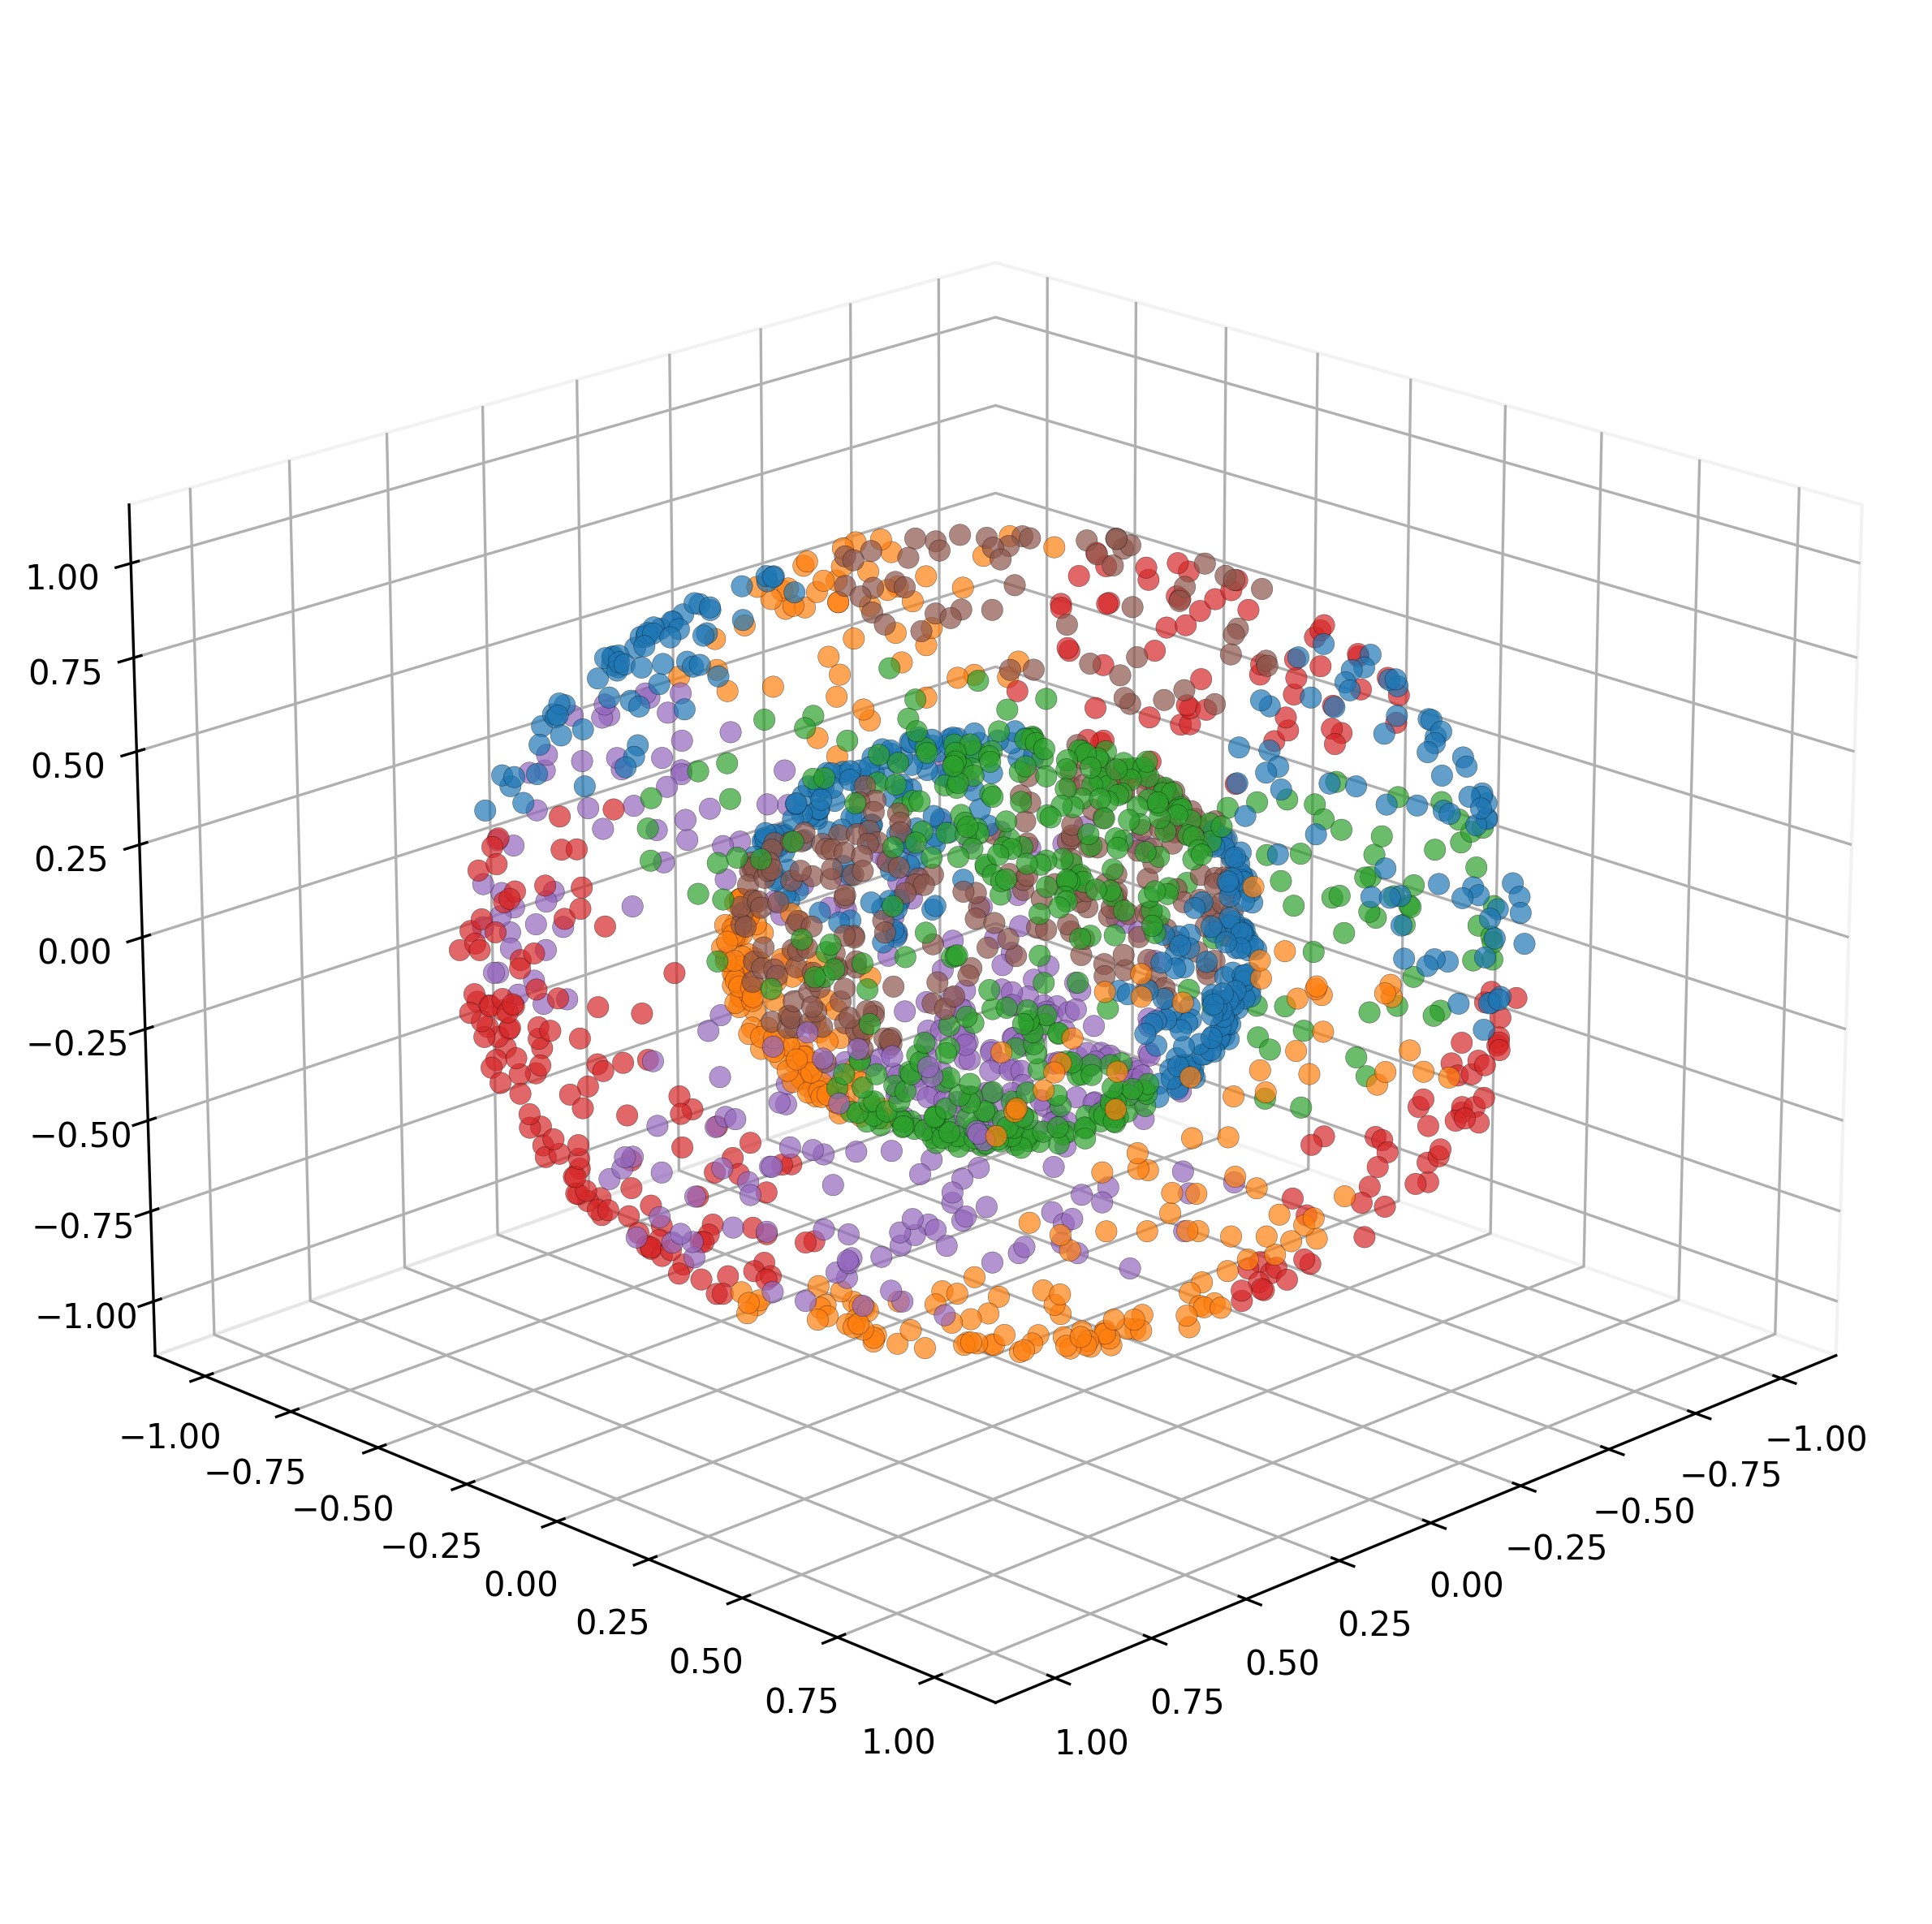

In [25]:
model = "KMeans"
fig, ax, result = plot_3d_example(
    n_spheres, radius_separation, radius_std, n_samples, model, seed_dataset, n_trials=n_trials
)
plt.tight_layout()
fig.savefig(results_dir / f"{model}_spherical_clusters_3d.pdf", dpi=300)

# KMeans with n_clusters=2

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

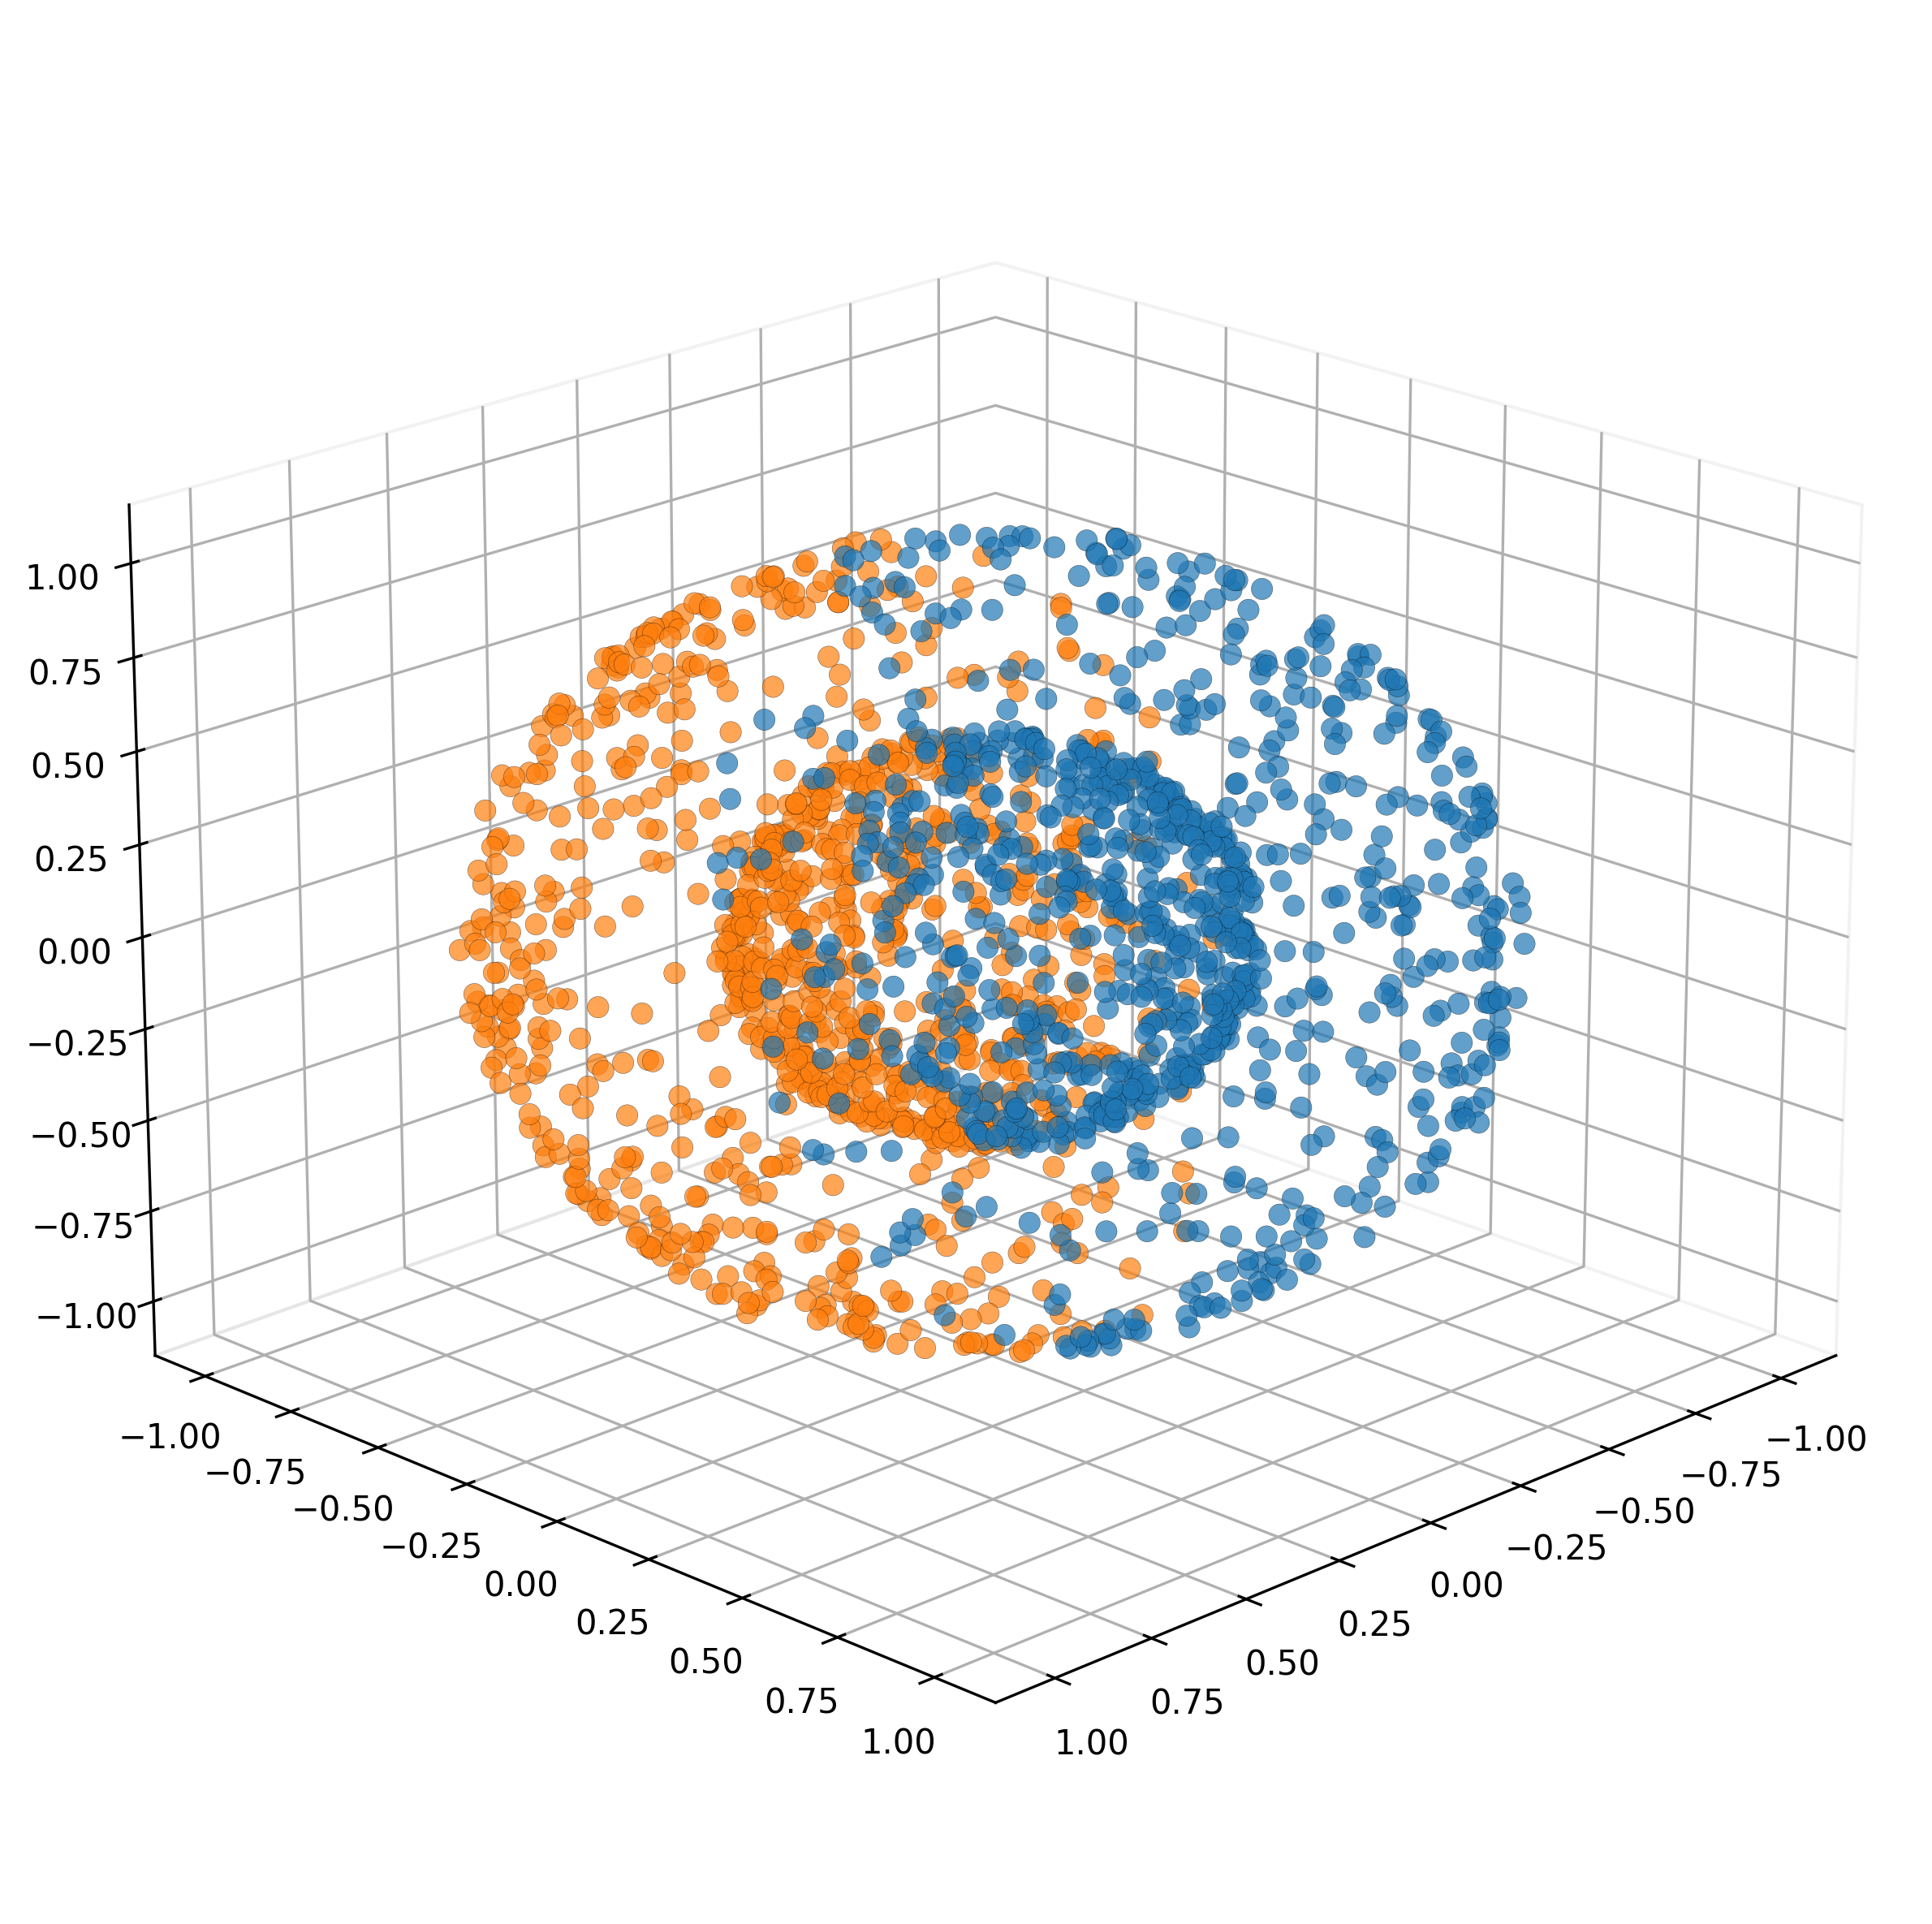

In [26]:
model = "KMeans"
fig, ax, result = plot_3d_example(n_spheres, radius_separation, radius_std, n_samples, model, seed_dataset, n_trials=n_trials, model_params={"n_clusters": 2})
plt.tight_layout()
fig.savefig(results_dir / f"{model}_n_clusters_2_spherical_clusters_3d.pdf", dpi=300)

# CoHiRF DBSCAN

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

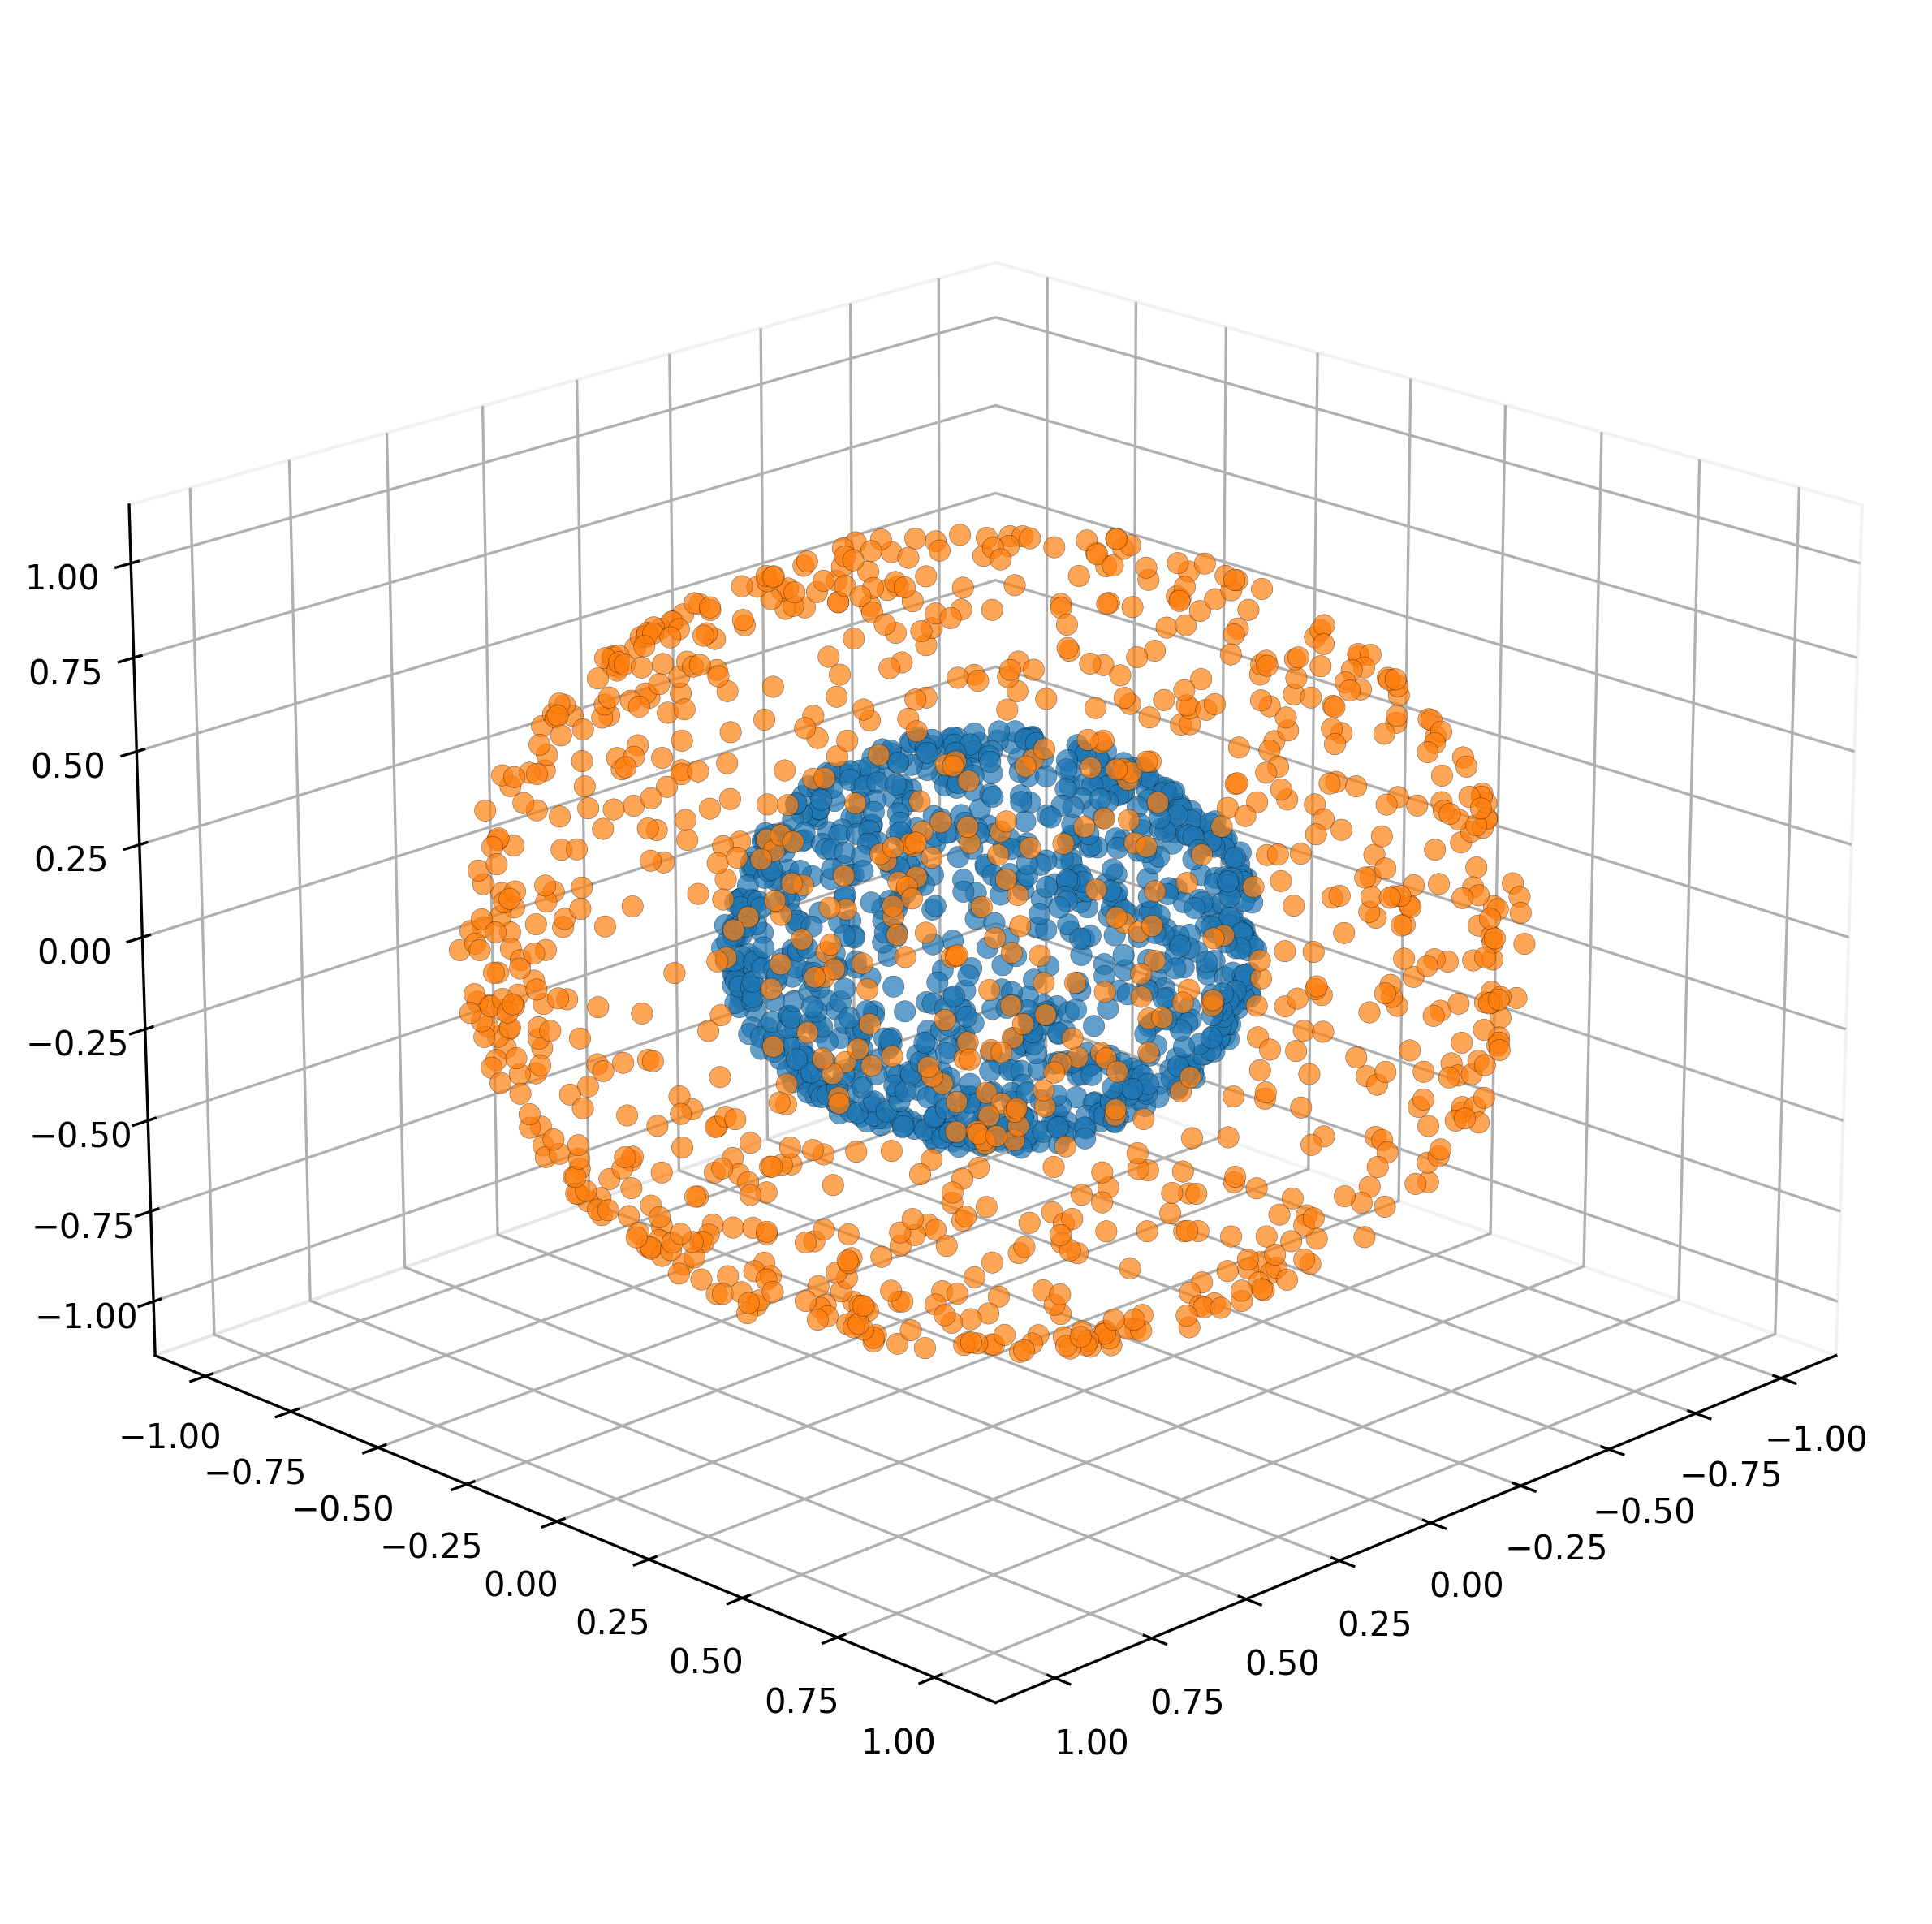

In [10]:
model = "CoHiRF-DBSCAN"
fig, ax, result = plot_3d_example(
    n_spheres, radius_separation, radius_std, n_samples, model, seed_dataset, n_trials=n_trials
)
plt.tight_layout()
fig.savefig(results_dir / f"{model}_spherical_clusters_3d.pdf", dpi=300)